In [1]:
from imm import imm
from lib.threshold_tree import ThresholdTree
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

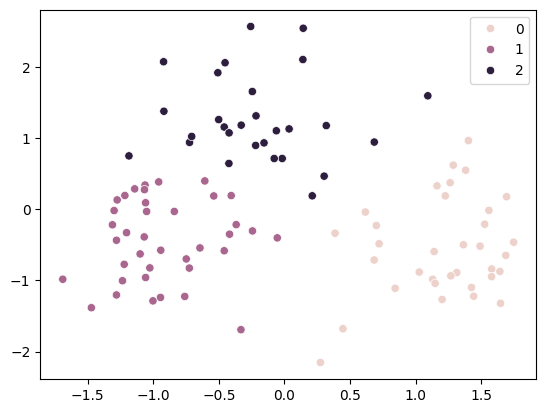

[[-0.21686734  1.31262032]
 [-1.18477497  0.75006345]
 [ 0.7206741  -0.48498287]
 [-0.94444483 -1.23974777]
 [-0.83913792 -0.03112463]
 [ 1.7458554  -0.46343811]
 [ 1.31219584 -0.89034386]
 [ 0.14016925  2.10417478]
 [ 1.02656751 -0.88267953]
 [ 0.30209713  0.46523561]]


In [58]:
dims = 2
n = 100
k = 3
min_impurity_decrease = 0.00001
threshold_change = 0.01
robustness_factor = 0.7

X, _y = make_blobs(centers=k, cluster_std=1.2, n_features=dims, n_samples=n)
data = load_wine()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k)
model.fit(X)
centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
else:
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
plt.show()


print(X[:10])

In [ ]:
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")

Instance shape: 2

Instance class: 0, point: [ 0.7206741  -0.48498287]
Target center class: 2, point: [-0.20986467  1.26771338]



DTC accuracy: 1.0

Instance: [ 0.7206741  -0.48498287]
Instance prediction : [0]

[[ 0.23266183 -0.48498288]
 [ 0.34159714  0.4415774 ]
 [ 0.7206741   0.79206592]
 [ 0.23266183 -0.48498288]
 [ 0.34159714  1.01987259]
 [ 0.7206741   1.12501914]]
CF predictions:  [0 2 2 0 2 2]


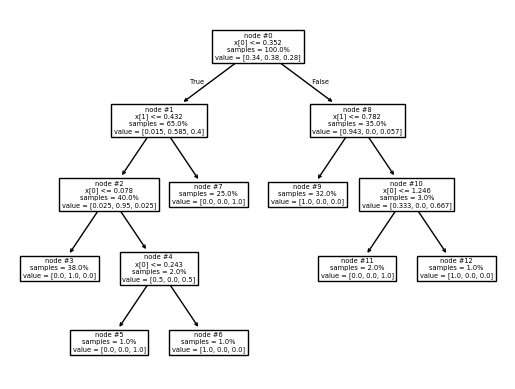

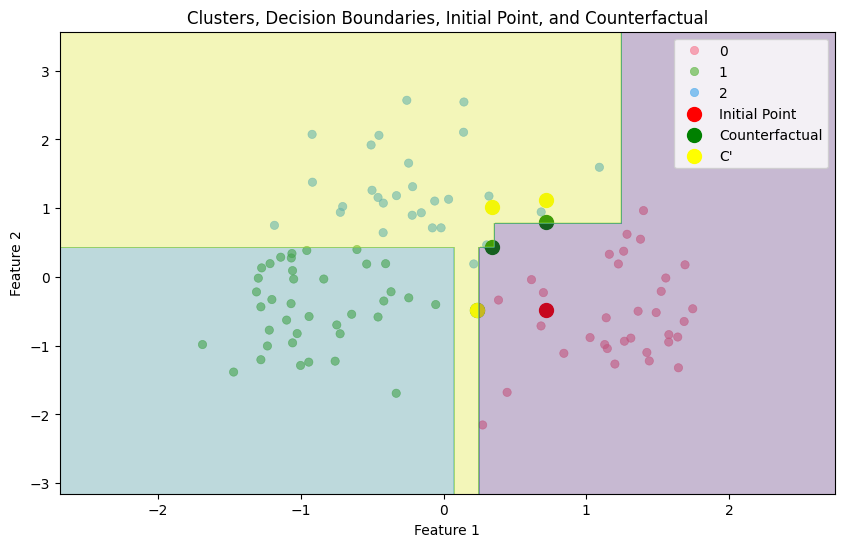

In [69]:
threshold_tree = ThresholdTree(model, centers, X, y)

cfs = threshold_tree.find_counterfactuals_DTC(instance, target_class, min_impurity_decrease=min_impurity_decrease, threshold_change=threshold_change, robustness_factor=robustness_factor)
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(cfs)
print(f'CF predictions: ', model.predict(cfs))
threshold_tree.print_DTC_tree()
threshold_tree.plot_DTC_tree()

Instance:  [ 0.7206741  -0.48498287]
Counterfactual:  [0.13074121 0.42428001]

Original class:  [0]
Counterfactual class:  [2]
├── L0: f0 < 0.14074121180691523
│   ├── L1: f1 < 0.41428001161521144
│   │   ├── L2, C: 1
│   │   └── L2, C: 2
│   └── L1, C: 0



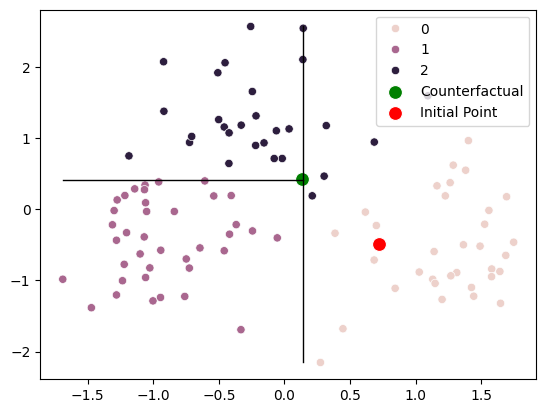

In [77]:
cf = threshold_tree.find_counterfactuals_IMM(instance, target_class, threshold_change=threshold_change)
print("Instance: ", instance)
print("Counterfactual: ", cf)
print("")
print("Original class: ", model.predict([instance]))
print("Counterfactual class: ", model.predict([cf]))
threshold_tree.print_IMM_tree()
threshold_tree.plot_IMM_tree()